## Warmup - basic klayout

Docs: https://www.klayout.de/doc-qt5/code/module_db.html

In [1]:
import klayout.db as pya

layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

## pya.DBox

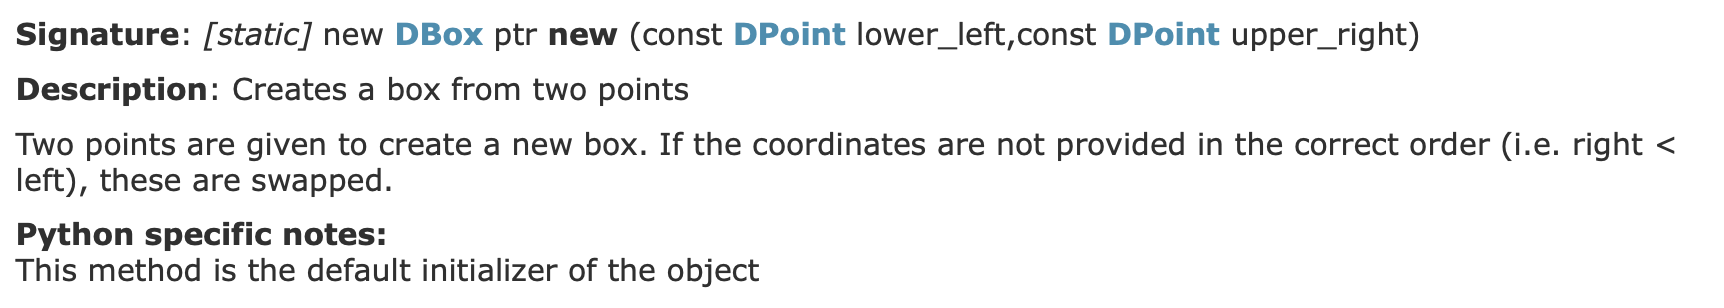

In [2]:
box = pya.DBox(pya.DPoint(0, 10), pya.DPoint(10, 30))

In [6]:
layer1 = pya.LayerInfo(1, 0)
TOP.shapes(layout.layer(layer1)).insert(box)
layout.write('demo2_box.gds')
del TOP, layout

In [5]:
!open demo2_box.gds

## Warmup - zeropdk box

```python
def layout_box(cell, layer, point1, point3, ex):
    """ Lays out a box

    Args:
        point1: bottom-left point
        point3: top-right point

    """

    ey = rotate90(ex)
    polygon = box(point1, point3, ex, ey)
    insert_shape(cell, layer, polygon)
    return polygon
```

In [10]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")
layer1 = pya.LayerInfo(1, 0)

from zeropdk.layout import layout_box

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

layout_box(TOP, layer1, 10 * ey, 10 * ex + 30 * ey, ex)
layout.write('demo2_box_zeropdk.gds')
del layout, TOP

In [9]:
!open 'demo2_box_zeropdk.gds'

In [15]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")
layer1 = pya.LayerInfo(1, 0)
layer2 = pya.LayerInfo(2, 0)

from zeropdk.layout import layout_box

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

from zeropdk.layout.geometry import rotate
import numpy as np
# def rotate(point, angle_rad)
ex_rotated = rotate(ex, np.pi / 6)

layout_box(TOP, layer1, 10 * ey, 10 * ex + 30 * ey, ex_rotated)
layout_box(TOP, layer2, 10 * ey, 10 * ex + 30 * ey, ex)
layout.write('demo2_box_zeropdk.gds')
del layout, TOP

In [16]:
!open 'demo2_box_zeropdk.gds'

## Warmed up... - zeropdk waveguides

```python

# zeropdk.layout.waveguides

def layout_waveguide(cell, layer, points_list, width, smooth=False):
    """ Lays out a waveguide (or trace) with a certain width along given points.

    This is very useful for laying out Bezier curves with or without adiabatic tapers.

    Args:
        cell: cell to place into
        layer: layer to place into. It is done with cell.shapes(layer).insert(pya.Polygon)
        points_list: list of pya.DPoint (at least 2 points)
        width (microns): constant or list. If list, then it has to have the same length as points
        smooth: tries to smooth final polygons to avoid very sharp edges (greater than 130 deg)

    """
    pass

# zeropdk.layout.geometry
def bezier_optimal(P0, P3, angle0, angle3):
    """ Computes the optimal bezier curve from P0 to P3 with angles 0 and 3

    Args:
        P0, P3: Point
        Angles in degrees
    """
    pass
```

In [18]:
from zeropdk.layout.waveguides import layout_waveguide
from zeropdk.layout.geometry import bezier_optimal

layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")
layer1 = pya.LayerInfo(1, 0)
layer2 = pya.LayerInfo(2, 0)

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)

points_list = bezier_optimal(0 * ex, 10 * ex + 10 * ey, 0, 0)
layout_waveguide(TOP, layer1, points_list, 0.5)
layout.write('demo2_waveguide_zeropdk.gds')
del layout, TOP

Warning! Min radius: 2.57 um


In [19]:
!open 'demo2_waveguide_zeropdk.gds'

I am annoyed by the repeated code. Simplify this with a decorator perhaps...

```python
from contextlib import contextmanager

@contextmanager
def managed_resource(*args, **kwds):
    # Code to acquire resource, e.g.:
    resource = acquire_resource(*args, **kwds)
    try:
        yield resource
    finally:
        # Code to release resource, e.g.:
        release_resource(resource)

>>> with managed_resource(timeout=3600) as resource:
```

## Getting hot... - zeropdk SiEPIC gds cell


```python
def GDSCell(cell_name, filename, gds_dir):
    """
        Args:
            cell_name: cell within that file.
            filename: is the gds file name.
            gds_dir: where to look for file

        Returns:
            (class) a GDS_cell_base class that can be inherited
    """
    pass
```

In [25]:
from zeropdk.pcell import GDSCell

BDC_Class = GDSCell("ebeam_bdc_te1550", filename="ebeam_bdc_te1550.gds", gds_dir="gds_cells/")

layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

bdc_cell = BDC_Class('Test BDC').get_gds_cell(layout)

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)
origin = 0 * ex + 0 * ey

#cell_insert_cell(cell: Cell, other_cell: Cell, origin: DPoint, angle: float degrees):

TOP.insert_cell(bdc_cell, origin, 0)
layout.write('demo2_bdc_zeropdk.gds')

In [26]:
!open 'demo2_bdc_zeropdk.gds'

## Hot... Almost done. GDSCell from zeropdk


I created the file `ebeam_pdk.py` with some nice classes for us to use. This is essentially a bare-minimum PDK based on SiEPIC EBeam's.

In [35]:
from ebeam_pdk import GDSCell, TECHLAYERS
from zeropdk.pcell import Port

class Broadband_DC_te1550(GDSCell("ebeam_bdc_te1550", filename="ebeam_bdc_te1550.gds")):
    """
    The PCell version of directional coupler
    """

    def draw(self, cell):
        cell = self.draw_gds_cell(cell)
        _, ex, ey = self.origin_ex_ey()

        opt1_position = -35.45 * ex + 2.35 * ey
        opt2_position = -35.45 * ex - 2.35 * ey
        opt3_position = 35.3 * ex + 2.35 * ey
        opt4_position = 35.3 * ex - 2.35 * ey

        ports = [
            Port("opt1", opt1_position, -ex, 0.5),
            Port("opt2", opt2_position, -ex, 0.5),
            Port("opt3", opt3_position, ex, 0.5),
            Port("opt4", opt4_position, ex, 0.5),
        ]

        return cell, {port.name: port for port in ports}

In [55]:
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)
origin = 0 * ex + 0 * ey

bdc_cell_ports1 = Broadband_DC_te1550('Test BDC', params=dict(angle_ex=10)).place_cell(TOP, origin)
bdc_cell_ports2 = Broadband_DC_te1550('Test BDC').place_cell(TOP, origin + 100 * ex + 10 * ey)

for port in bdc_cell_ports1.values():
    port.draw(TOP, TECHLAYERS["PinRec"])

layout.write('demo2_bdc_ebeampdk.gds')

In [56]:
!open 'demo2_bdc_ebeampdk.gds'

In [57]:
bdc_cell_ports1, bdc_cell_ports2

({'opt1': (opt1, -35.3195080618,-3.84152967871),
  'opt2': (opt2, -34.5033616268,-8.47012611787),
  'opt3': (opt3, 34.3556404638,8.44407889122),
  'opt4': (opt4, 35.1717868988,3.81548245206)},
 {'opt1': (opt1, 64.55,12.35),
  'opt2': (opt2, 64.55,7.65),
  'opt3': (opt3, 135.3,12.35),
  'opt4': (opt4, 135.3,7.65)})

Let's connect the two BDCs:

```python
# zeropdk.layout.routing
def layout_connect_ports(cell, layer, port_from, port_to, smooth=True):
    """ Places an "optimal" bezier curve from port_from to port_to.
    """
```

In [58]:
from zeropdk.layout.routing import layout_connect_ports

layout_connect_ports(TOP, TECHLAYERS['Si'], bdc_cell_ports1['opt3'], bdc_cell_ports2['opt1'])
layout_connect_ports(TOP, TECHLAYERS['Si'], bdc_cell_ports1['opt4'], bdc_cell_ports2['opt2'])
layout_connect_ports(TOP, TECHLAYERS['Si'], bdc_cell_ports2['opt3'], bdc_cell_ports2['opt4'])

layout.write('demo2_bdc_ebeampdk.gds')
del layout, TOP

Warning! Min radius: 1.43 um
